In [51]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [52]:
#设置LSTM的时间窗
window=1
#读取数据
df1=pd.read_table("train-small.txt",sep=',',header=0)
#df1=pd.read_table("train-small.txt",sep=',',header=0)
#df1.to_csv('train-small.txt', sep=',',index=False)
df1=df1.iloc[:10000,1:]
df1.tail()

E:\anoconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


,Open,High,Low,Close,Volume
9994,1.22198,1.22226,1.22198,1.22226,386.8
9995,1.22210,1.22219,1.22203,1.22208,404.3
9996,1.22214,1.22230,1.22200,1.22223,939.1
9997,1.22230,1.22230,1.22203,1.22217,689.0
9998,1.22203,1.22229,1.22200,1.22229,610.9


In [53]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df1 = pd.DataFrame(df0, columns=df1.columns)
df1.tail()

,Open,High,Low,Close,Volume
9994,0.843910,0.846502,0.849716,0.854737,0.027970
9995,0.847519,0.844391,0.851210,0.849323,0.029578
9996,0.848722,0.847708,0.850314,0.853835,0.078703
9997,0.853534,0.847708,0.851210,0.852030,0.055730
9998,0.845414,0.847407,0.850314,0.855639,0.048556


In [54]:
#调整列顺序
cols=list(df1)
cols.insert(0,cols.pop(cols.index('Volume ')))
df1=df1[cols]

In [55]:
#计算得出标签
record=(df1['Close'][1:].values-df1['Close'][0:-1].values)>0
classification=[0]
for i in record:
    if(i==True):
        classification.append(1)
    else:
        classification.append(0)
classification
df1['label']=classification    
df1.tail()

,Volume,Open,High,Low,Close,label
9994,0.027970,0.843910,0.846502,0.849716,0.854737,1
9995,0.029578,0.847519,0.844391,0.851210,0.849323,0
9996,0.078703,0.848722,0.847708,0.850314,0.853835,1
9997,0.055730,0.853534,0.847708,0.851210,0.852030,0
9998,0.048556,0.845414,0.847407,0.850314,0.855639,1


In [56]:
#构建LSTM输入
stock=df1
seq_len=window
input_size=len(df1.iloc[1,:])
amount_of_features = len(stock.columns)#有几列
data = stock.as_matrix() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度5+1
result = []
for index in range(len(data) - sequence_length):#循环170-5次
    result.append(data[index: index + sequence_length])#第i行到i+5
result = np.array(result)#得到161个样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]
#reshape成 5天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
X_train.shape,X_test.shape

E:\anoconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


((8997, 1, 6), (1000, 1, 6))

In [57]:
#建立LSTM模型 训练
d = 0.01
model = Sequential()
model.add(LSTM(64, input_shape=(window, input_size), return_sequences=False))
model.add(Dropout(d))
model.add(Dense(32,init='uniform',activation='relu'))        
model.add(Dense(1,init='uniform',activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch = 100, batch_size = 200,validation_data=(X_test, y_test)) #训练模型1000次

E:\anoconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  
E:\anoconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  import sys
E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 8997 samples, validate on 1000 samples
Epoch 1/100
8997/8997 [==============================] - 3s 297us/step - loss: 0.6923 - accuracy: 0.5136 - val_loss: 0.6912 - val_accuracy: 0.5270
Epoch 2/100
8997/8997 [==============================] - 0s 36us/step - loss: 0.6876 - accuracy: 0.5457 - val_loss: 0.6883 - val_accuracy: 0.5410
Epoch 3/100
8997/8997 [==============================] - 0s 39us/step - loss: 0.6815 - accuracy: 0.5770 - val_loss: 0.6938 - val_accuracy: 0.5410
Epoch 4/100
8997/8997 [==============================] - 0s 35us/step - loss: 0.6812 - accuracy: 0.5770 - val_loss: 0.6935 - val_accuracy: 0.5410
Epoch 5/100
8997/8997 [==============================] - 0s 27us/step - loss: 0.6813 - accuracy: 0.5770 - val_loss: 0.6922 - val_accuracy: 0.5410
Epoch 6/100
8997/8997 [==============================] - 0s 23us/step - loss: 0.6811 - accuracy: 0.5770 - val_loss: 0.6919 - val_accuracy: 0.5410
Epoch 7/100
8997/8997 [==============================] - 0s 21us/step - los

8997/8997 [==============================] - 0s 21us/step - loss: 0.6804 - accuracy: 0.5764 - val_loss: 0.6878 - val_accuracy: 0.5420
Epoch 57/100
8997/8997 [==============================] - 0s 23us/step - loss: 0.6803 - accuracy: 0.5767 - val_loss: 0.6874 - val_accuracy: 0.5420
Epoch 58/100
8997/8997 [==============================] - 0s 21us/step - loss: 0.6802 - accuracy: 0.5765 - val_loss: 0.6881 - val_accuracy: 0.5430
Epoch 59/100
8997/8997 [==============================] - 0s 23us/step - loss: 0.6804 - accuracy: 0.5767 - val_loss: 0.6877 - val_accuracy: 0.5420
Epoch 60/100
8997/8997 [==============================] - 0s 22us/step - loss: 0.6803 - accuracy: 0.5765 - val_loss: 0.6878 - val_accuracy: 0.5420
Epoch 61/100
8997/8997 [==============================] - 0s 22us/step - loss: 0.6803 - accuracy: 0.5766 - val_loss: 0.6874 - val_accuracy: 0.5420
Epoch 62/100
8997/8997 [==============================] - 0s 21us/step - loss: 0.6803 - accuracy: 0.5764 - val_loss: 0.6879 - val_a

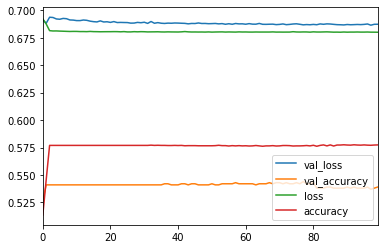

In [58]:
#画出迭代曲线
pd.DataFrame(model.history.history).plot()

In [59]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]
y_train_predict>0.5
y_train_predict=[int(i) for i in y_train_predict>0.5]
y_train_predict=np.array(y_train_predict)
from sklearn import metrics
print("精确度等指标：")
print(metrics.classification_report(y_train,y_train_predict))
print("混淆矩阵：")
print(metrics.confusion_matrix(y_train,y_train_predict))

精确度等指标：
              precision    recall  f1-score   support

         0.0       0.59      0.56      0.58      4631
         1.0       0.56      0.59      0.58      4366

    accuracy                           0.58      8997
   macro avg       0.58      0.58      0.58      8997
weighted avg       0.58      0.58      0.58      8997

混淆矩阵：
[[2601 2030]
 [1775 2591]]


In [60]:
#在测试集上的拟合结果
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
y_test_predict>0.5
y_test_predict=[int(i) for i in y_test_predict>0.5]
y_test_predict=np.array(y_test_predict)
from sklearn import metrics
print("精确度等指标：")
print(metrics.classification_report(y_test,y_test_predict))
print("混淆矩阵：")
print(metrics.confusion_matrix(y_test,y_test_predict))

精确度等指标：
              precision    recall  f1-score   support

         0.0       0.57      0.51      0.54       527
         1.0       0.51      0.57      0.54       473

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000

混淆矩阵：
[[271 256]
 [205 268]]
